# Event Detection Example

### Load data from Michibiki-1 Magnetometers and create data gap

c:\ProgramData\Anaconda3\lib\site-packages\pymssa\mssa.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


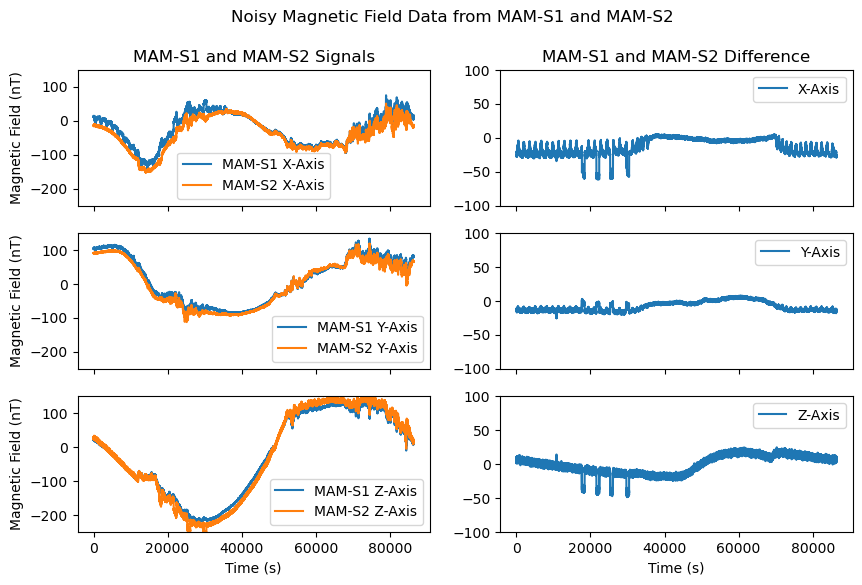

In [1]:
"Import the necessary modules"
from magprime import utility
import numpy as np
import matplotlib.pyplot as plt


B = utility.load_michibiki_data() # shape = (n_sensor, n_axis, n_samples)

"Decimate the data to 0.1 Hz because UBSS and MSSA are slow methods and it will take a long time to run on 86,400 data points"
#B = B[:,:,::10]

"Create a 3 x 2-panel plot of MAM-S1 and MAM-S2 data with overlapping magnetometers in the same panel"
fig, axs = plt.subplots(3, 2, figsize=(10, 6), sharex=True)
fig.suptitle("Noisy Magnetic Field Data from MAM-S1 and MAM-S2")
axs[0,0].set_title("MAM-S1 and MAM-S2 Signals")
axs[0,0].plot(B[0,0], label="MAM-S1 X-Axis")
axs[0,0].plot(B[1,0], label="MAM-S2 X-Axis")
axs[0,0].set_ylabel("Magnetic Field (nT)")
axs[0,0].set_ylim(-250, 150)
axs[0,0].legend()

axs[1,0].plot(B[0,1], label="MAM-S1 Y-Axis")
axs[1,0].plot(B[1,1], label="MAM-S2 Y-Axis")
axs[1,0].set_ylabel("Magnetic Field (nT)")
axs[1,0].set_ylim(-250, 150)
axs[1,0].legend()

axs[2,0].plot(B[0,2], label="MAM-S1 Z-Axis")
axs[2,0].plot(B[1,2], label="MAM-S2 Z-Axis")
axs[2,0].set_xlabel("Time (s)")
axs[2,0].set_ylabel("Magnetic Field (nT)")
axs[2,0].set_ylim(-250, 150)
axs[2,0].legend()

axs[0,1].set_title("MAM-S1 and MAM-S2 Difference")
axs[0,1].plot(B[1,0]-B[0,0], label="X-Axis")
axs[0,1].legend()
axs[0,1].set_ylim(-100, 100)

axs[1,1].plot(B[1,1]-B[0,1], label="Y-Axis")
axs[1,1].legend()
axs[1,1].set_ylim(-100, 100)

axs[2,1].plot(B[1,2]-B[0,2], label="Z-Axis")
axs[2,1].set_ylim(-100, 100)
axs[2,1].set_xlabel("Time (s)")
axs[2,1].legend()

plt.show()



### Clean Data with WAIC-UP

c:\ProgramData\Anaconda3\lib\site-packages\magprime\algorithms\WAICUP.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  result[axis] = cleanWAICUP(B[:,axis,:])


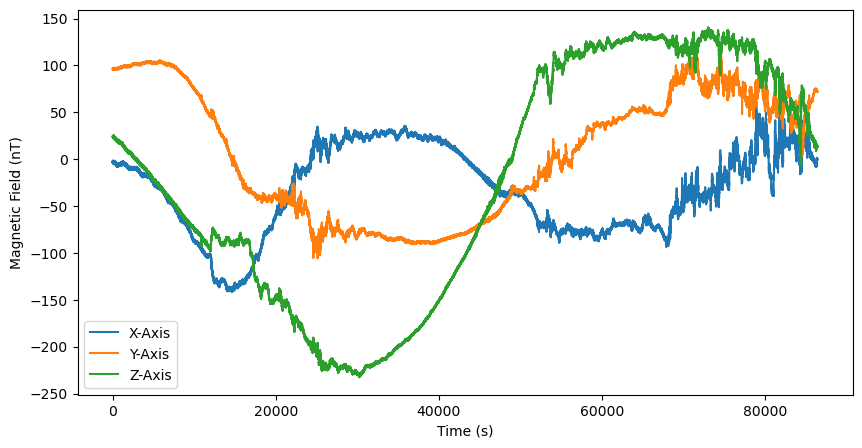

In [2]:
from magprime.algorithms import WAICUP

"Detrend the data"
WAICUP.uf = 1000
WAICUP.detrend = True

"Algorithm Parameters"
WAICUP.fs = 1
WAICUP.dj = 1/8

"Clean the data"
B_waicup = WAICUP.clean(np.copy(B))

"Plot the data"
plt.figure(figsize=(10, 5))
plt.plot(B_waicup[0], label="X-Axis")
plt.plot(B_waicup[1], label="Y-Axis")
plt.plot(B_waicup[2], label="Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Magnetic Field (nT)")
plt.legend()


### Detect Auroral Oval with EventDetector

In [3]:
from algorithms import EventDetector
import importlib
importlib.reload(EventDetector)
window_length = 600 # 5 sec
nu = 0.3
fs = 1
EventDetector.use_fft = True
EventDetector.save_segments = True
bz_anomaly_flags = EventDetector.anomaly_detection(np.copy(B_waicup[2]), fs, window_length, nu)


FFT applied


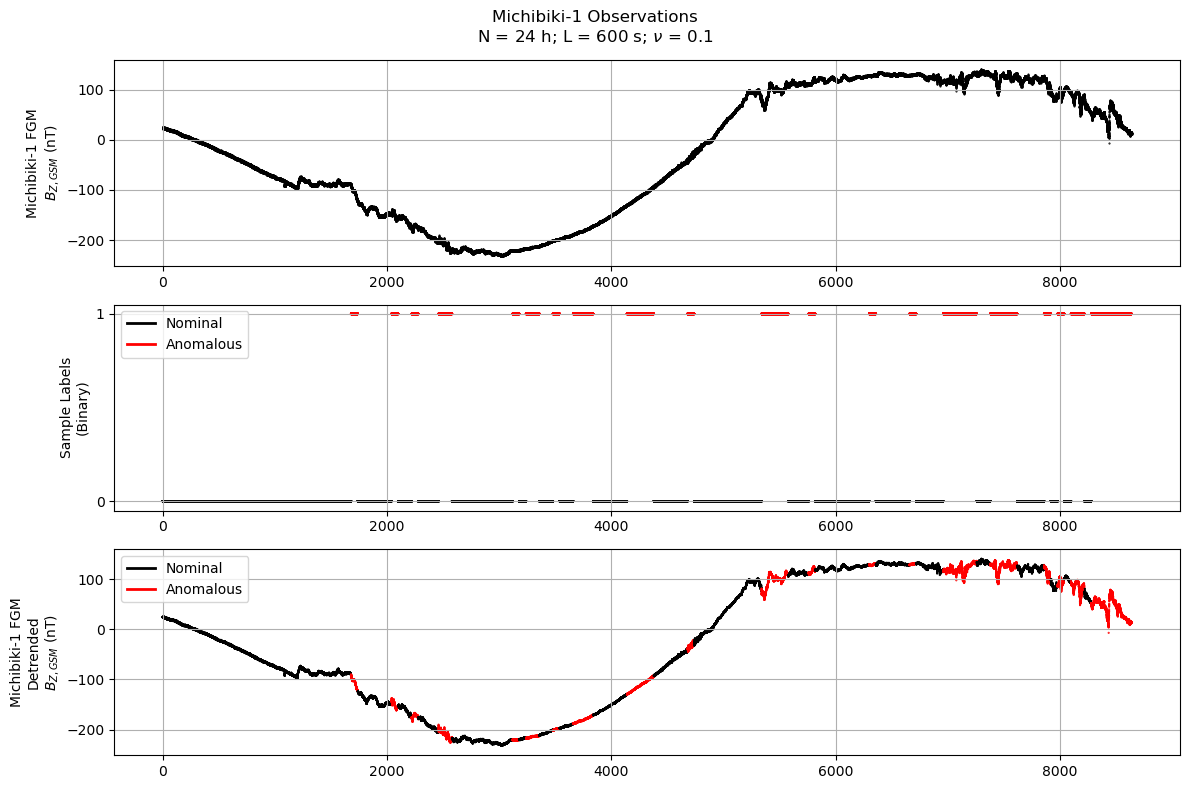

In [9]:
# Develop cmap for scatterplots
bz_colormap = ['red' if bz_anomaly_flags[i] > 0 else 'black' for i in range(len(bz_anomaly_flags))]
t = np.arange(0, len(B_waicup[2])/10, 0.1)

# Plot
plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.scatter(t,B_waicup[2], color='black', s=1, marker='.')
plt.ylabel('Michibiki-1 FGM\n$B_{Z,GSM}$ (nT)')
plt.grid()
plt.subplot(3,1,2)
plt.scatter(t, bz_anomaly_flags, marker='.', color=bz_colormap, s=2)
plt.yticks([0, 1])
plt.grid()
plt.ylabel('Sample Labels\n(Binary)')
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='black', linewidth=2),
                Line2D([0], [0], color='red', linewidth=2)]
plt.legend(custom_lines, ['Nominal', 'Anomalous'])
plt.subplot(3,1,3)
plt.scatter(t, B_waicup[2], color=bz_colormap, s=1, marker='.')
plt.ylabel('Michibiki-1 FGM\nDetrended\n$B_{Z,GSM}$ (nT)')
plt.grid()
plt.legend(custom_lines, ['Nominal', 'Anomalous'])
plt.suptitle('Michibiki-1 Observations\nN = 24 h; L = 600 s; $\\nu$ = 0.1')
plt.tight_layout()

{'segment_index': 140, 'start_index': 84000, 'stop_index': 84600, 'anomaly_score': -16.453615736407304}


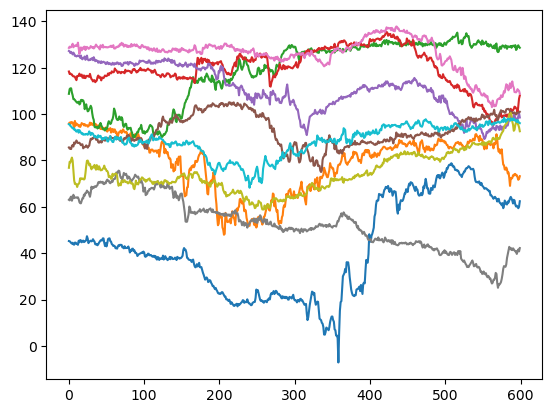

In [5]:
"Plot the most significant Events"
#plt.figure(figsize=(10, 5))
print(EventDetector.events[window_length][0])
for i in range(10):
    event = EventDetector.events[window_length][i]
    plt.plot(B_waicup[2][event["start_index"]:event["stop_index"]], label="Z-Axis")

In [32]:
from sklearn.decomposition import PCA
import numpy as np
from scipy.ndimage import uniform_filter1d
from scipy.fft import rfft
import hdbscan

# General Parameters
uf = 400                # Uniform Filter Size for detrending
detrend_data = False    # Detrend the data
use_fft = False         # Use FFT for feature extraction
save_segments = False   # Save the segment indices for visualization

# Variables for Anomaly Detection
events = {}             # Dictionary to store detected events

def multiscale_anomaly_detection(input_data, sampling_rate_hz, initial_window_length_sec,
                                 min_window_length_sec, max_window_length_sec):
    """
    Performs multiscale anomaly detection on input_data using HDBSCAN and a sliding window.
    """
    anomaly_flags = np.zeros(len(input_data))

    # Start the recursive detection with the initial window length
    recursive_detection(
        data=input_data,
        global_start_idx=0,
        current_window_length_sec=initial_window_length_sec,
        anomaly_flags=anomaly_flags,
        sampling_rate_hz=sampling_rate_hz,
        min_window_length_sec=min_window_length_sec,
        max_window_length_sec=max_window_length_sec
    )

    return anomaly_flags

def recursive_detection(data, global_start_idx, current_window_length_sec, anomaly_flags,
                        sampling_rate_hz, min_window_length_sec, max_window_length_sec):
    """
    Recursively detects anomalies in the data at multiple scales using a sliding window.
    """
    window_length = int(current_window_length_sec * sampling_rate_hz)

    if (current_window_length_sec < min_window_length_sec or
        current_window_length_sec > max_window_length_sec or
        len(data) < window_length):
        return

    # Define step size for sliding window (e.g., 50% overlap)
    step_size = window_length // 2

    # Number of windows
    num_steps = (len(data) - window_length) // step_size + 1

    # Handle cases where data is too short
    if num_steps <= 0:
        return

    segments = []
    segment_starts = []

    for i in range(num_steps):
        start = i * step_size
        end = start + window_length
        segments.append(data[start:end])
        segment_starts.append(start)

    # Optional FFT Transformation
    if use_fft:
        segments_fft = np.abs(rfft(segments, axis=1))
        features = segments_fft
    else:
        features = segments

    # Dimensionality Reduction via PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(features)

    # Clustering via HDBSCAN
    clusterer = hdbscan.HDBSCAN()
    cluster_labels = clusterer.fit_predict(principal_components)

    # In HDBSCAN, label -1 corresponds to noise (anomalies)
    anomalies = np.where(cluster_labels == -1)[0]

    for idx in anomalies:
        # For each anomalous segment
        window_start = segment_starts[idx]
        window_end = window_start + window_length

        # Map to global indices
        global_window_start = global_start_idx + window_start
        global_window_end = global_start_idx + window_end

        # Ensure indices are within bounds
        global_window_start = max(0, global_window_start)
        global_window_end = min(len(anomaly_flags), global_window_end)

        # Update the anomaly_flags
        anomaly_flags[global_window_start:global_window_end] += 1

        # Extract anomalous segment
        segment_data = data[window_start:window_end]

        # Prepare for next recursion
        next_window_length_sec = current_window_length_sec / 5

        # Recursive call
        recursive_detection(
            data=segment_data,
            global_start_idx=global_window_start,
            current_window_length_sec=next_window_length_sec,
            anomaly_flags=anomaly_flags,
            sampling_rate_hz=sampling_rate_hz,
            min_window_length_sec=min_window_length_sec,
            max_window_length_sec=max_window_length_sec
        )

# Detrending by uniform filter
def detrend(signal, filt_length):
    trend = uniform_filter1d(signal, size=filt_length)
    signal_detrended = signal - trend
    return signal_detrended, trend


In [35]:
sampling_rate_hz = 1  # Sampling rate in Hz
initial_window_length_sec = 1000  # Initial (coarsest) window length in seconds
min_window_length_sec = 30  # Minimum window length in seconds
max_window_length_sec = 1000  # Maximum window length in seconds
nu_value = None  # Not used in HDBSCAN

# Run the multiscale anomaly detection
anomaly_flags = multiscale_anomaly_detection(
    B_waicup[2],
    sampling_rate_hz,
    initial_window_length_sec,
    min_window_length_sec,
    max_window_length_sec
)


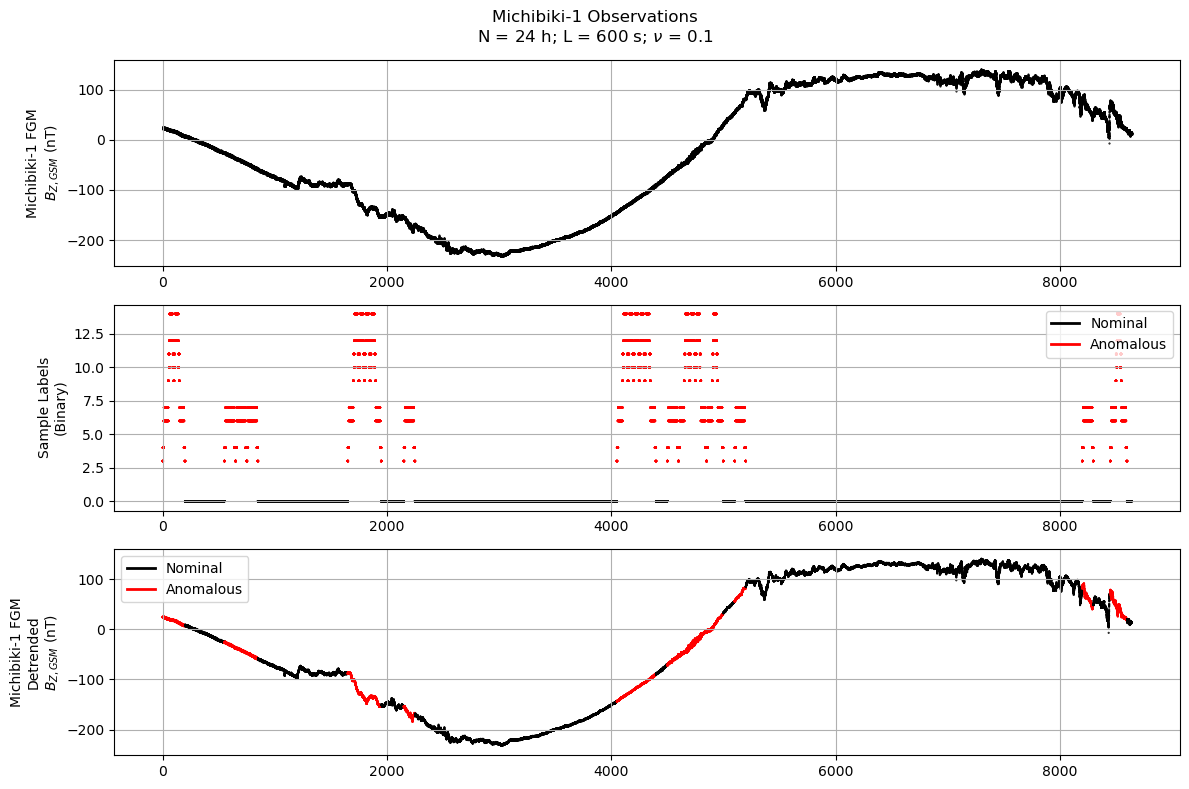

In [37]:
# Develop cmap for scatterplots
bz_colormap = ['red' if anomaly_flags[i] > 0 else 'black' for i in range(len(bz_anomaly_flags))]
t = np.arange(0, len(B_waicup[2])/10, 0.1)

# Plot
plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.scatter(t,B_waicup[2], color='black', s=1, marker='.')
plt.ylabel('Michibiki-1 FGM\n$B_{Z,GSM}$ (nT)')
plt.grid()
plt.subplot(3,1,2)
plt.scatter(t, anomaly_flags, marker='.', color=bz_colormap, s=2)
#plt.yticks([0, 1])
plt.grid()
plt.ylabel('Sample Labels\n(Binary)')
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='black', linewidth=2),
                Line2D([0], [0], color='red', linewidth=2)]
plt.legend(custom_lines, ['Nominal', 'Anomalous'])
plt.subplot(3,1,3)
plt.scatter(t, B_waicup[2], color=bz_colormap, s=1, marker='.')
plt.ylabel('Michibiki-1 FGM\nDetrended\n$B_{Z,GSM}$ (nT)')
plt.grid()
plt.legend(custom_lines, ['Nominal', 'Anomalous'])
plt.suptitle('Michibiki-1 Observations\nN = 24 h; L = 600 s; $\\nu$ = 0.1')
plt.tight_layout()

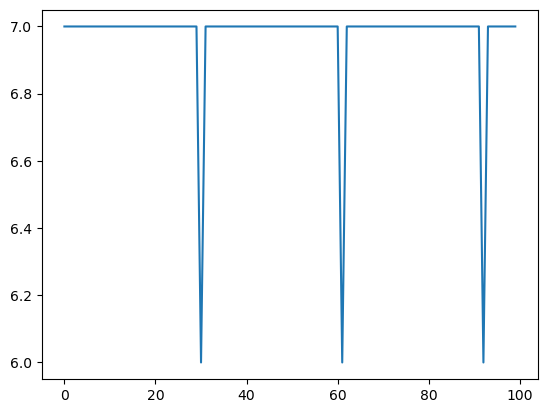

In [22]:
plt.plot(anomaly_flags[:100])